In [31]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as func
from datetime import datetime


In [4]:
import pandas as pd


In [72]:
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv("/home/ulysses/Downloads/us-counties.csv")

In [9]:
data.columns

Index(['date', 'county', 'state', 'cases', 'deaths'], dtype='object')

In [8]:
# 转为txt 文件格式
with open(
    "/mnt/data1/workspace/data_analysis_mining/Python_Spark/demo/us-counties.txt",
    'a+',
    encoding='utf8'
    ) as f:
    for line in data.values:
        f.write((str(line[0])+'\t'+str(line[1])+'\t'
                +str(line[2])+'\t'+str(line[3])+'\t'+str(line[4])+'\n'))
        

In [3]:
spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()

In [14]:
schema = StructType([
    StructField('date', DateType(), False),
    StructField('county', StringType(), False),
    StructField('state', StringType(), False),
    StructField('cases', IntegerType(), False),
    StructField('deaths', IntegerType(), False),
])

In [15]:
rdd0 = spark.sparkContext.textFile("/mnt/data1/workspace/data_analysis_mining/Python_Spark/demo/us-counties.txt")

In [24]:
datetime.strptime('2020/1/11', '%Y/%m/%d')

datetime.datetime(2020, 1, 11, 0, 0)

In [26]:
def todate(input_str):
    return datetime.strptime(input_str, '%Y/%m/%d')

In [27]:
rdd1 = rdd0 \
    .map(lambda x: x.split('\t')) \
    .map(lambda l: Row(todate(l[0]), l[1], l[2], int(l[3]), int(l[4])))

In [28]:
info = spark.createDataFrame(rdd1, schema=schema)

In [54]:
info.createOrReplaceTempView('usinfo')

In [33]:
# #1.计算每日的累计确诊病例数和死亡数
df1 = info.groupBy('date').agg(func.sum('cases'), func.sum('deaths')).sort(info['date'].asc())

In [36]:
df1 = df1.withColumnRenamed('sum(cases)', 'cases').withColumnRenamed("sum(deaths)", 'deaths')

In [73]:
pdf1 = df1.toPandas()
pdf1

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0
...,...,...,...
115,2020-05-15,1450964,87434
116,2020-05-16,1474612,88660
117,2020-05-17,1493597,89504
118,2020-05-18,1515373,90293


In [81]:
from matplotlib.dates import bytespdate2num, num2date
from matplotlib.ticker import Formatter
import numpy as np
class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%Y-%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(np.round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''

        return num2date(self.dates[ind]).strftime(self.fmt)

formatter = MyFormatter(pdf1['date'])

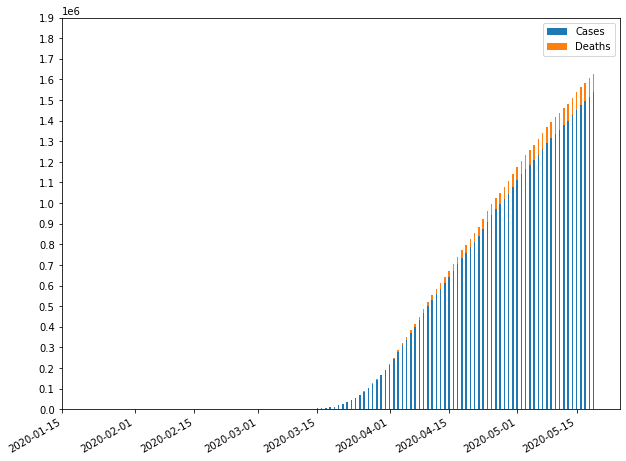

In [93]:
fig, ax = plt.subplots(figsize=(10, 8))
# ax.xaxis.set_major_formatter(formatter)
width=0.35
death = pdf1.deaths
case = pdf1.cases
p1 = plt.bar(pdf1.date, case, width)
p2 = plt.bar(pdf1.date, death, width, bottom=case)
fig.autofmt_xdate()
plt.legend((p1[0], p2[0]), ('Cases', 'Deaths'))
plt.yticks(np.arange(0, 2*1e6, 1e5))
plt.show()

In [38]:
df1.repartition(1).write.json('result1.json')

In [46]:
#注册为临时表供下一步使用
df1.createOrReplaceTempView('ustotal')

In [ ]:
spark

In [48]:
#2.计算每日较昨日的新增确诊病例数和死亡病例数
# 新增 = 今 - 昨 所以考虑使用自连接，连接条件是t1.date = t2.date + 1，然后使用t1.totalCases – t2.totalCases计算该日新增
df2 = spark.sql("""
    select 
        t1.date,
        t1.cases-t2.cases as caseIncrease, 
        t1.deaths-t2.deaths as deathIncrease
    from
        ustotal t1
    join
        ustotal t2
    on
        t1.date = date_add(t2.date,1)
""")

In [49]:
df2.show()

+----------+------------+-------------+
|      date|caseIncrease|deathIncrease|
+----------+------------+-------------+
|2020-04-30|       30425|         2211|
|2020-03-07|         117|            4|
|2020-03-13|         556|            7|
|2020-02-04|           0|            0|
|2020-02-15|           0|            0|
|2020-02-12|           1|            0|
|2020-05-08|       27654|         1573|
|2020-04-29|       26510|         2514|
|2020-05-10|       20159|          931|
|2020-01-25|           1|            0|
|2020-04-26|       26598|         1246|
|2020-04-21|       25488|         2668|
|2020-03-09|         201|            4|
|2020-03-10|         270|            5|
|2020-03-11|         245|            6|
|2020-04-19|       25354|         1518|
|2020-02-11|           0|            0|
|2020-04-13|       25787|         1762|
|2020-05-17|       18985|          844|
|2020-02-25|           2|            0|
+----------+------------+-------------+
only showing top 20 rows



In [50]:
# 根据日期排序
df2.sort(df2.date.asc()).repartition(1).write.json("result2.json")

In [55]:
#3.统计截止5.19日 美国各州的累计确诊人数和死亡人数
# 首先筛选出5.19日的数据，然后以state作为分组字段，对cases和deaths字段进行汇总统计
df3 = spark.sql("""
    select
        date,
        state, 
        sum(cases) as totalCase,
        sum(deaths) as totalDeath,
        round(sum(deaths)/sum(cases), 4) as DeathRate
    from usinfo
    where date = to_date("2020-05-19", "yyyy-MM-dd")
    group by date, state
""")

In [56]:
df3.show(10)

+----------+--------------------+---------+----------+---------+
|      date|               state|totalCase|totalDeath|DeathRate|
+----------+--------------------+---------+----------+---------+
|2020-05-19|Northern Mariana ...|       21|         2|   0.0952|
|2020-05-19|            Oklahoma|     5489|       294|   0.0536|
|2020-05-19|         Connecticut|    38430|      3472|   0.0903|
|2020-05-19|             Florida|    46936|      2051|   0.0437|
|2020-05-19|District of Columbia|     7434|       400|   0.0538|
|2020-05-19|               Maine|     1741|        73|   0.0419|
|2020-05-19|           Wisconsin|    13001|       467|   0.0359|
|2020-05-19|              Hawaii|      631|        17|   0.0269|
|2020-05-19|          California|    83981|      3422|   0.0407|
|2020-05-19|      Virgin Islands|       69|         6|    0.087|
+----------+--------------------+---------+----------+---------+
only showing top 10 rows



In [57]:
df3.sort(df3.totalCase.desc()).repartition(1).write.json('result3.json')
df3.createOrReplaceTempView("eachStateInfo")

In [58]:
#4.找出美国确诊最多的10个州
df4 = spark.sql("select date, state, totalCase from eachStateInfo order by totalCase desc limit 10")

In [59]:
df4.show()

+----------+-------------+---------+
|      date|        state|totalCase|
+----------+-------------+---------+
|2020-05-19|     New York|   357757|
|2020-05-19|   New Jersey|   149037|
|2020-05-19|     Illinois|    98298|
|2020-05-19|Massachusetts|    87925|
|2020-05-19|   California|    83981|
|2020-05-19| Pennsylvania|    67404|
|2020-05-19|     Michigan|    52337|
|2020-05-19|        Texas|    51080|
|2020-05-19|      Florida|    46936|
|2020-05-19|     Maryland|    41664|
+----------+-------------+---------+



In [60]:
df4.repartition(1).write.json('result4.json')

In [61]:
#5.找出美国死亡最多的10个州
df5 = spark.sql("select date, state, totalDeath from eachStateInfo order by totalDeath desc limit 10")
df5.show()

+----------+-------------+----------+
|      date|        state|totalDeath|
+----------+-------------+----------+
|2020-05-19|     New York|     28437|
|2020-05-19|   New Jersey|     10586|
|2020-05-19|Massachusetts|      5938|
|2020-05-19|     Michigan|      5017|
|2020-05-19| Pennsylvania|      4675|
|2020-05-19|     Illinois|      4399|
|2020-05-19|  Connecticut|      3472|
|2020-05-19|   California|      3422|
|2020-05-19|    Louisiana|      2581|
|2020-05-19|     Maryland|      2081|
+----------+-------------+----------+



In [62]:
df5.repartition(1).write.json("result5.json")

In [63]:
#6.找出美国确诊最少的10个州
df6 = spark.sql("select date, state, totalCase from eachStateInfo order by totalCase asc limit 10")
df6.show()

+----------+--------------------+---------+
|      date|               state|totalCase|
+----------+--------------------+---------+
|2020-05-19|Northern Mariana ...|       21|
|2020-05-19|      Virgin Islands|       69|
|2020-05-19|              Alaska|      399|
|2020-05-19|             Montana|      471|
|2020-05-19|              Hawaii|      631|
|2020-05-19|             Wyoming|      776|
|2020-05-19|             Vermont|      944|
|2020-05-19|                Guam|     1123|
|2020-05-19|       West Virginia|     1514|
|2020-05-19|               Maine|     1741|
+----------+--------------------+---------+



In [64]:
df6.repartition(1).write.json("result6.json")

In [65]:
#7.找出美国死亡最少的10个州
df7 = spark.sql("select date, state, totalDeath from eachStateInfo order by totalDeath asc limit 10")
df7.show()

+----------+--------------------+----------+
|      date|               state|totalDeath|
+----------+--------------------+----------+
|2020-05-19|Northern Mariana ...|         2|
|2020-05-19|      Virgin Islands|         6|
|2020-05-19|                Guam|         6|
|2020-05-19|              Alaska|         8|
|2020-05-19|             Wyoming|        10|
|2020-05-19|             Montana|        16|
|2020-05-19|              Hawaii|        17|
|2020-05-19|        North Dakota|        45|
|2020-05-19|        South Dakota|        46|
|2020-05-19|             Vermont|        54|
+----------+--------------------+----------+



In [66]:
df7.repartition(1).write.json("result7.json")

In [69]:
#8.统计截止5.19全美和各州的病死率
# 查询出全美的 再union eachStateInfo表
df8 = spark.sql("select 1 as sign,date,'USA' as state,round(sum(totalDeath)/sum(totalCase),4) as deathRate from eachStateInfo group by date union select 2 as sign,date,state,deathRate from eachStateInfo").cache()
df8.show()

+----+----------+-------------+---------+
|sign|      date|        state|deathRate|
+----+----------+-------------+---------+
|   2|2020-05-19|     Virginia|   0.0324|
|   2|2020-05-19|      Arizona|   0.0483|
|   2|2020-05-19| North Dakota|   0.0226|
|   2|2020-05-19|Massachusetts|   0.0675|
|   2|2020-05-19|   New Mexico|   0.0446|
|   2|2020-05-19|        Idaho|   0.0311|
|   2|2020-05-19|     Oklahoma|   0.0536|
|   2|2020-05-19|     Kentucky|    0.045|
|   2|2020-05-19|   California|   0.0407|
|   2|2020-05-19|         Utah|   0.0117|
|   2|2020-05-19| South Dakota|   0.0113|
|   2|2020-05-19|West Virginia|   0.0449|
|   2|2020-05-19|     Illinois|   0.0448|
|   2|2020-05-19|        Texas|   0.0275|
|   2|2020-05-19|       Oregon|   0.0376|
|   2|2020-05-19|     Maryland|   0.0499|
|   2|2020-05-19| Rhode Island|   0.0411|
|   2|2020-05-19|       Nevada|    0.052|
|   2|2020-05-19|       Hawaii|   0.0269|
|   2|2020-05-19|     Arkansas|   0.0207|
+----+----------+-------------+---

In [70]:
df8.select("*").filter("sign=1").show()

+----+----------+-----+---------+
|sign|      date|state|deathRate|
+----+----------+-----+---------+
|   1|2020-05-19|  USA|   0.0598|
+----+----------+-----+---------+



In [71]:
df8.sort(df8['sign'].asc(), df8['deathRate'].desc()).repartition(1).write.json("result8.json")